# Deep Learning &mdash; Assignment 1

First assignment for the 2020 Deep Learning course (NWI-IMC058) of the Radboud University.

_Gijs van Tulder (g.vantulder@cs.ru.nl) and Twan van Laarhoven (tvanlaarhoven@cs.ru.nl)_

_September 2020_

-----

**Names:** Mick Tuit and Maurice Verbrugge

**Group:** Group 1

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.

## Objectives

In this assignment you will
1. Experiment with gradient descent optimization;
2. Derive and implement gradients for binary cross-entropy loss, the sigmoid function and a linear layer;
3. Test your gradient implementations with the finite differences method;
4. Use these components to implement and train a simple neural network.

In [133]:
%matplotlib inline
import numpy as np
import scipy.optimize
import sklearn.datasets
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=6, linewidth=200)
plt.style.use('ggplot')

## 1.1 Gradient descent optimization

Consider the following function with two parameters and its derivatives:
\begin{align}
  f(x, y) &= x^2 + y^2 + x (y + 2) + \cos(3x) \\
  \frac{\partial f}{\partial x} &= 2x - 3\sin(3x) + y + 2 \\
  \frac{\partial f}{\partial y} &= x + 2y \\
\end{align}

In [134]:
def f(x, y):
    return x ** 2 + y ** 2 + x * (y + 2) + np.cos(3 * x)

def grad_x_f(x, y):
    return 2 * x - 3 * np.sin(3 * x) + y + 2
    
def grad_y_f(x, y):
    return x + 2 * y

A plot of the function shows that it has multiple local minima:

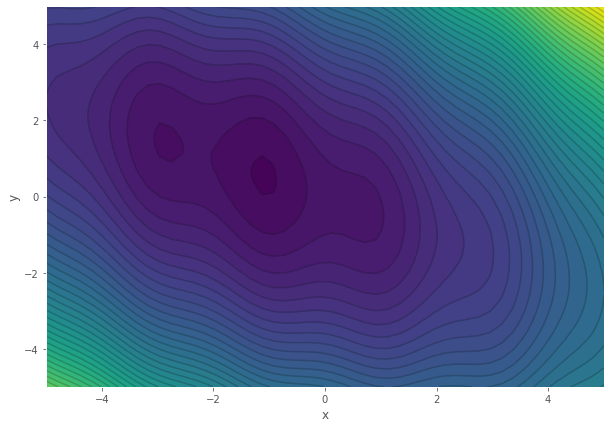

In [135]:
def plot_f_contours():
    xx, yy = np.meshgrid(np.linspace(-5, 5), np.linspace(-5, 5))
    zz = f(xx, yy)
    plt.contourf(xx, yy, zz, 50)
    plt.contour(xx, yy, zz, 50, alpha=0.2, colors='black', linestyles='solid')
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure(figsize=(10, 7))
plot_f_contours()


### Implement gradient descent

We would like to find the minimum of this function using gradient descent.

**Implement the gradient descent updates for $x$ and $y$ in the function below:**

In [231]:
def optimize_f(x, y, step_size, steps):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at the current point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        # apply the gradient descent updates to x and y
        x -= step_size * dx
        y -= step_size * dy

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

### Tune the parameters

We will now try if our optimization method works.

Use this helper function to plot the results:

In [232]:
# helper function that plots the results of the gradient descent optimization
def plot_gradient_descent_results(x, y, val, x_hist, y_hist):
    # plot the path on the contour plot
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plot_f_contours()
    plt.plot(x_hist, y_hist, '.-')
    
    # plot the learning curve
    plt.subplot(1, 2, 2)
    plt.plot(f(np.array(x_hist), np.array(y_hist)), '.r-')
    plt.title('Minimum value: %f' % f(x_hist[-1], y_hist[-1]))

**Run the gradient descent optimization with the following initial settings:**

``x=3, y=2, step_size=0.1, steps=10``

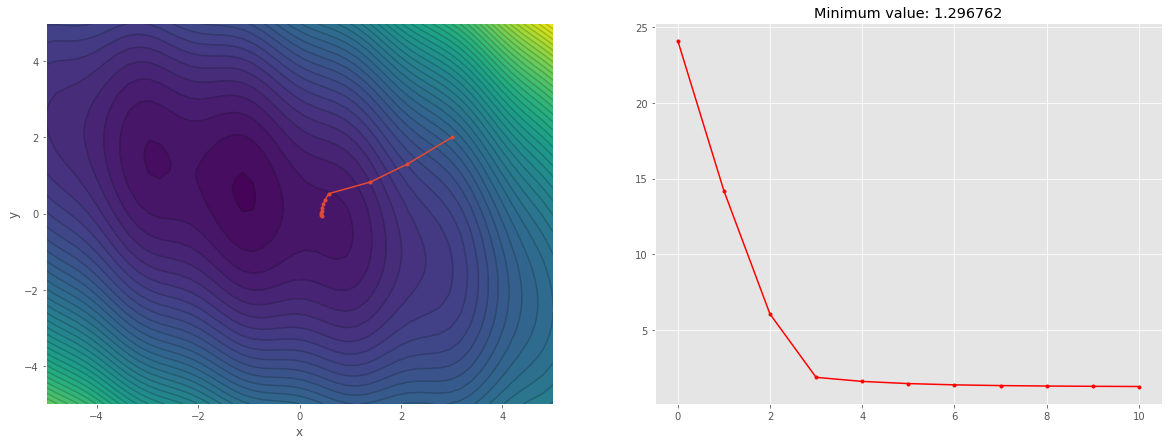

In [233]:
results = optimize_f(x=3, y=2, step_size=0.1, steps=10)
plot_gradient_descent_results(*results)

**Does it find the minimum of the function? What happens?**

No it does not, it gets stuck in a sort of local minimum plateau. The step size is too small to get out of the plateau. 

**Try a few different values for the `step_size` and the number of `steps` to get closes to the optimal solution:**

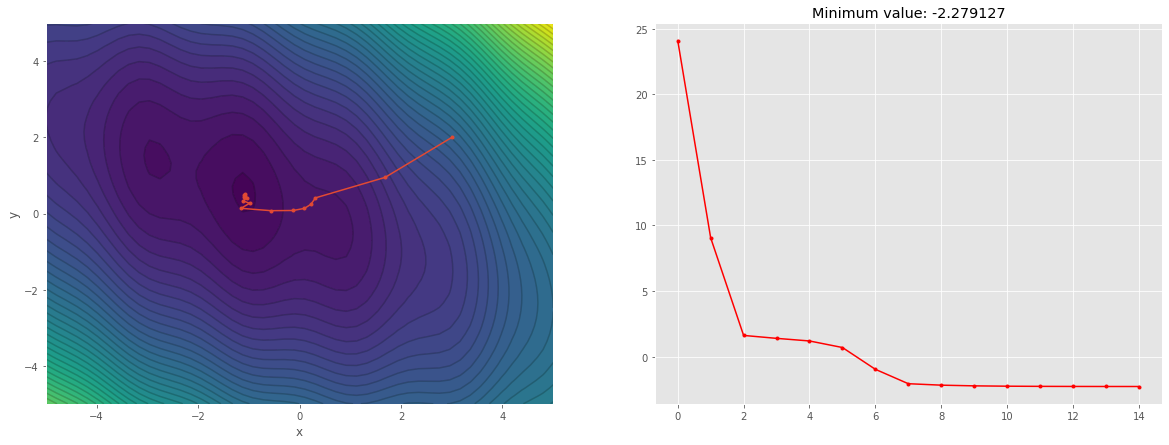

In [234]:
results = optimize_f(x=3, y=2, step_size=0.15, steps=14)
plot_gradient_descent_results(*results)

**Were you able to find a step size that reached the global optimum? If not, why not?**

Yes, using ```step_size = 0.15``` and ```steps = 14``` we were able to find the global optimum of -2.279127. If you keep increasing the number of steps the global optimum will become smaller and smaller however this is very minimal.

### Implement a decreasing step size

You might get better results if you use a step size that is large at the beginning, but slowly decreases during the optimization.

Try the following scheme to compute the step size $\eta_t$ in step $t$, given a decay parameter $d$:
\begin{align}
  \eta_t = \eta_0 d^t
\end{align}

**Update your optimization function to use this step size schedule:**

In [235]:
def optimize_f(x, y, step_size, steps, decay=1.0):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at this point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        # apply the gradient descent updates to x and y
        x -= step_size * dx
        y -= step_size * dy

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

        step_size = step_size * decay
    
    return x, y, f(x, y), x_hist, y_hist

**Tune the `step_sizes`, `steps` and `decay` parameters to get closer to the global minimum:**

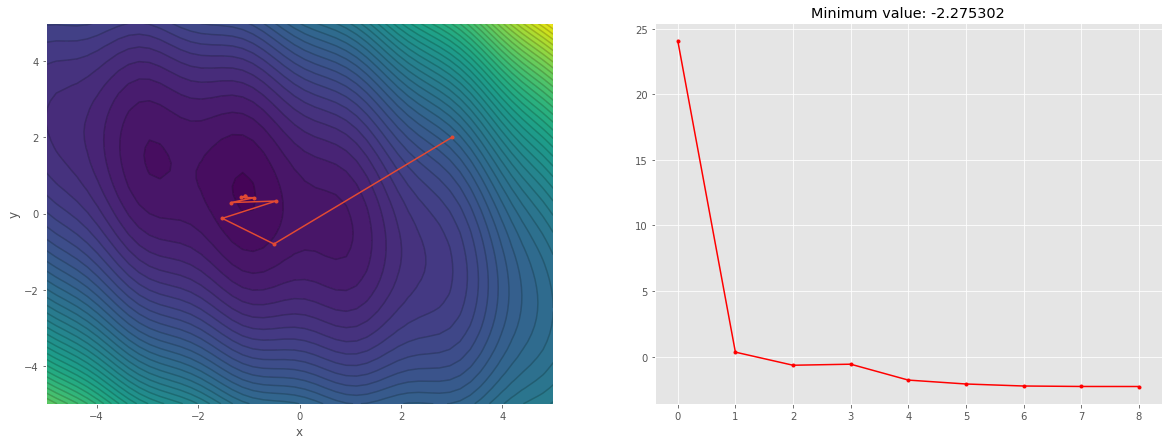

In [236]:
results = optimize_f(x=3, y=2, step_size=0.4, steps=8, decay=0.8)
plot_gradient_descent_results(*results)

We will now look at some more complex functions that we can try to optimize.

## 1.2 Neural network components

In this assignment, we will implement a simple neural network from scratch. We need four components:
1. A sigmoid activation function,
2. A ReLU activation function,
3. A binary cross-entropy loss function,
4. A linear layer.

For each component, we will implement the forward pass, the backward pass, and the gradient descent update.

### Sigmoid non-linearity

The sigmoid function is defined as:

\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}} \\
\end{align}

![Sigmoid](attachment:sigmoid.png)

**Give the derivative of the sigmoid function:**

Your answer here:

\begin{align} 
\frac{\partial \sigma(x)}{\partial x} &=  \frac{e^{-x}}{(1+e^{-x})^2}
\end{align}


**Implement the sigmoid and its gradient in the functions `sigmoid(x)` and `sigmoid_grad(x)`:**

In [247]:
def sigmoid(x):
    return 1 / (1 + np.e ** -x)

def sigmoid_grad(x):
    return (np.e ** -x) / ((1 + np.e ** -x) ** 2)

# try with a random input
x = np.random.uniform(-10, 10, size=5)
print('x:', x)
print('sigmoid(x):', sigmoid(x))
print('sigmoid_grad(x):', sigmoid_grad(x))

x: [ 5.192895  6.287264  4.898251 -3.637089  4.00408 ]
sigmoid(x): [0.994475 0.998144 0.992596 0.025653 0.982086]
sigmoid_grad(x): [0.005495 0.001853 0.00735  0.024995 0.017593]


To check that the gradient implementation is correct, we can compute the numerical derivative using the finite difference method. From [Chapter 11.5 of the Deep Learning book](http://www.deeplearningbook.org/contents/guidelines.html):

> Because
  \begin{align}
    f'(x) = \lim_{\epsilon \rightarrow 0} \frac{f(x + \epsilon) - f(x)}{ \epsilon},
  \end{align}
  we can approximate the derivative by using a small, finite $\epsilon$:
  \begin{align}
    f'(x) \approx \frac{f(x + \epsilon) - f(x)}{\epsilon}.
  \end{align}
  We can improve the accuracy of the approximation by using the centered difference:
  \begin{align}
    f'(x) \approx \frac{f(x + \frac{1}{2} \epsilon) - f(x - \frac{1}{2} \epsilon)}{\epsilon}.
  \end{align}
  The perturbation size $\epsilon$ must be large enough to ensure that the perturbation is not rounded down too much by ﬁnite-precision numerical computations.

**Use the central difference method to check your implementation of the sigmoid gradient. Compute the numerical gradient and check that it is close to the symbolic gradient computed by your implementation:**

In [271]:
# start with some random inputs
x = np.random.uniform(-2, 2, size=5)

# compute the symbolic gradient
print('Symbolic', sigmoid_grad(x))

# DONE: compute the numerical gradient
epsilon = 1e-3

def sigmoid_numerical_grad(x, epsilon):
    return (sigmoid(x + 0.5 * epsilon) - sigmoid(x - 0.5 * epsilon)) / epsilon

print('Numeric', sigmoid_numerical_grad(x, epsilon))

Symbolic [0.232976 0.133858 0.216922 0.143728 0.229924]
Numeric [0.232976 0.133858 0.216922 0.143728 0.229924]


**Is the gradient computed with finite differences exactly the same as the analytic answer? Why (not)?**

DONE: Your answer here.

Yes, the differences are exactly the same. 

**If there is a visible difference between the two gradients, please try to make this a small as possible before you continue.**

## Rectified linear units (ReLU)

The rectified linear unit is defined as:
\begin{align}
  f(x) = \max(0, x)
\end{align}

![relu.png](attachment:relu.png)

**Give the derivative of the ReLU function:**

DONE: Your answer here.

\begin{align} \frac{\partial f(x)}{\partial x} &= 
\begin{equation}
    \begin{cases}
      0, & \text{if}\ x \leq 0 \\
      1, & \text{if}\ x > 0
    \end{cases}
\end{equation}
\end{align}


**Implement the ReLU function and its gradient in the functions `relu(x)` and `relu_grad(x)`. Use the finite differences method to check that the gradient is correct:**

In [ ]:
def relu(x):
    # TODO: implement the relu function
    raise NotImplementedError

def relu_grad(x):
    # TODO: implement the gradient of the relu function
    raise NotImplementedError

# try with a random input
x = np.random.uniform(-10, 10, size=5)
print('x:', x)
print('relu(x):', relu(x))
print('relu_grad(x):', relu_grad(x))
print()

# TODO: compute and compare the symbolic and numerical gradients


### Comparing sigmoid and ReLU

The sigmoid and ReLU activation functions have slightly different characteristics.

**Run the code below to plot the sigmoid and ReLU activation functions and their gradients:**

In [ ]:
x = np.linspace(-10, 10, 100)

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(x, sigmoid(x), label='Sigmoid')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(x, relu(x), label='ReLU')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(x, sigmoid_grad(x), label='Sigmoid gradient')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(x, relu_grad(x), label='ReLU gradient')
plt.xlabel('x')
plt.legend(loc='upper left');

**Which activation function would you recommend for a network that outputs probabilities, i.e., outputs $\in (0, 1)$? Why?**

TODO: Your answer here.

**Compare the gradients for sigmoid and ReLU. What are the advantages and disadvantages of each activation function?**

TODO: Your answer here.

### Binary cross-entropy loss

We will use the binary cross-entropy loss to train our network. This loss function is useful for binary classification.

The binary cross-entropy (BCE) is a function of the ground truth label $y \in \{0, 1\}$ and the predicted label $\hat{y} \in (0, 1)$:

\begin{align}
  \mathcal{L} &= -(y \log{\hat{y}} + (1-y) \log(1-\hat{y})) \\
\end{align}

To minimize the BCE loss with gradient descent, we need to compute the gradient with respect to the prediction $\hat{y}$.

**Derive the gradient for the BCE loss:**

TODO: Your answer here.

\begin{align}
\frac{\partial \mathcal{L}}{\partial \hat{y}} &=
\end{align}


**Implement `bce_loss(y, y_hat)` and `bce_loss_grad(y, y_hat)` and use the finite differences method to check that the gradient is correct:**

In [ ]:
def bce_loss(y, y_hat):
    # TODO: implement the BCE loss
    raise NotImplementedError

def bce_loss_grad(y, y_hat):
    # TODO: implement the gradient of the BCE loss
    raise NotImplementedError

# try with some random inputs
y = np.random.randint(2, size=5)
y_hat = np.random.uniform(0, 1, size=5)
print('y:', y)
print('y_hat:', y_hat)
print('bceloss(y, y_hat):', bce_loss(y, y_hat))
print()

# TODO: compute and compare the symbolic and numerical gradients


### Linear layer

Finally, we need to compute the gradients for the linear layer in our network.

Define a linear model $\mathbf{y} = \mathbf{x} \mathbf{W} + \mathbf{b}$, where
* $\mathbf{x}$ is an input vector of shape $N$,
* $\mathbf{W}$ is a weight matrix of shape $N \times M$,
* $\mathbf{b}$ is a bias vector of shape $M$,
* $\mathbf{y}$ is the output vector of shape $M$.

**Derive the gradients for $\mathbf{y}$ with respect to the input $\mathbf{x}$ and the parameters $\mathbf{W}$ and $\mathbf{b}$:**

TODO: Your answer here.

\begin{align}
  \nabla_\mathbf{x} \mathbf{y} &= \\
  \nabla_\mathbf{W} \mathbf{y} &= \\
  \nabla_\mathbf{b} \mathbf{y} &= \\
\end{align}


**Given the gradient $\nabla_\mathbf{y} \mathcal{L}$ for the loss w.r.t. $\mathbf{y}$, use the chain rule to derive the gradients for the loss w.r.t. $\mathbf{x}$, $\mathbf{W}$ and $\mathbf{b}$:**

TODO: Your answer here.

\begin{align}
  \nabla_\mathbf{x} \mathcal{L} &= \\
  \nabla_\mathbf{W} \mathcal{L} &= \\
  \nabla_\mathbf{b} \mathcal{L} &= \\
\end{align}


## 1.3 Implement a one-layer model

We can now implement a simple one-layer model with a sigmoid activation:

1. Given an input vector $\mathbf{x}$, weight vector $\mathbf{w}$ and bias $b$, compute the output $\hat{y}$:

\begin{align}
h = \mathbf{x}^T \mathbf{w} + b \\
\hat{y} = \sigma(h) \\
\end{align}

2. Compute the BCE loss comparing the prediction $\hat{y}$ with the ground-truth label $y$.

3. Compute the gradient for the BCE loss and back-propagate this to get the gradient of $\mathcal{L}$ w.r.t. $\mathbf{x}$:

\begin{align}
  \nabla_\mathbf{x} \mathcal{L} =
\end{align}

**Complete the implementation below:**

In [ ]:
# initialize parameters
w = np.random.uniform(size=5)
b = np.random.rand()

# implement the model
def fn(x, y):
    # TODO: forward: compute h, y_hat, loss
    h = 0
    y_hat = 0
    loss = 0
    
    # TODO: backward: compute grad_y_hat, grad_h, grad_x
    grad_y_hat = 0
    grad_h = 0
    grad_x = 0
    
    return loss, grad_x

# test with a random input
x = np.random.uniform(size=5)
y = 1

loss, grad_x = fn(x, y)
print("Loss", loss)
print("Gradient", grad_x)

**Use the finite-difference method to check the gradient $\nabla_\mathbf{x} \mathcal{L}$:**

In [ ]:
# start with some random inputs
x = np.random.uniform(size=5)
y = 1

# set epsilon to a small value
eps = 0.00001

numerical_grad = np.zeros(x.shape)
# compute the gradient for each element of x separately
for i in range(len(x)):
    # compute inputs at -eps/2 and +eps/2
    x_a, x_b = x.copy(), x.copy()
    x_a[i] += eps / 2
    x_b[i] -= eps / 2

    # compute the gradient for this element
    loss_a, _ = fn(x_a, y)
    loss_b, _ = fn(x_b, y)
    numerical_grad[i] = (loss_a - loss_b) / eps

# compute the symbolic gradient
loss, symbolic_grad = fn(x, y)
    
print("Symbolic gradient")
print(symbolic_grad)
print("Numerical gradient")
print(numerical_grad)

## 1.4 Implement a linear layer and the sigmoid and ReLU activation functions

We will now construct a simple neural network. We need to implement the folowing objects:
* `Linear`: a layer that computes `y = x*W + b`.
* `Sigmoid`: a layer that computes `y = sigmoid(x)`.
* `ReLU`: a layer that computes `y = relu(x)`.

For each layer class, we need to implement the following methods:
* `forward`: The forward pass that computes the output `y` given `x`.
* `backward`: The backward pass that receives the gradient for `y` and computes the gradients for the input `x` and the parameters of the layer.
* `step`: The update step that applies the gradient updates to the weights, based on the gradient computed by `backward`.

**Implement a class `Linear` that computes `y = x*W + b`:**

In [ ]:
# Computes y = x * w + b.
class Linear:
    def __init__(self, n_in, n_out):
        # initialize the weights randomly,
        # using the Xavier initialization rule for scale
        a = np.sqrt(6 / (n_in * n_out))
        self.W = np.random.uniform(-a, a, size=(n_in, n_out))
        self.b = np.zeros((n_out,))

    def forward(self, x):
        # TODO: compute the forward pass
        y = 0  # TODO
        return y

    def backward(self, x, dy):
        # TODO: compute the backward pass,
        # given dy, compute the gradients for x, W and b
        dx = 0       # TODO
        self.dW = 0  # TODO
        self.db = 0  # TODO
        return dx
    
    def step(self, step):
        # TODO: apply a gradient descent update step
        self.W = self.W  # TODO
        self.b = self.b  # TODO
        
    def __str__(self):
        return 'Linear %dx%d' % self.W.shape


# Try the new class with some random values.
# Debugging tip: always choose a unique length for each
# dimension, so you'll get an error if you mix them up.
x = np.random.uniform(size=(3, 5))

layer = Linear(5, 7)
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

**Implement a class `Sigmoid` that computes `y = 1 / (1 + exp(-x))`:**

In [ ]:
# Computes y = 1 / (1 + exp(-x)).
class Sigmoid:
    def forward(self, x):
        # TODO: compute the forward pass
        raise NotImplementedError  # TODO

    def backward(self, x, dy):
        # TODO: compute the backward pass,
        # return the gradient for x given dy
        raise NotImplementedError  # TODO
    
    def step(self, step_size):
        raise NotImplementedError  # TODO
    
    def __str__(self):
        return 'Sigmoid'


# try the new class with some random values
x = np.random.uniform(size=(3, 5))

layer = Sigmoid()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

**Implement a class `ReLU` that computes `y = max(0, x)`:**

In [ ]:
# Computes y = max(0, x).
class ReLU:
    def forward(self, x):
        # TODO: compute the forward pass
        raise NotImplementedError  # TODO

    def backward(self, x, dy):
        # TODO: compute the backward pass,
        # return the gradient for x given dy
        raise NotImplementedError  # TODO
    
    def step(self, step_size):
        raise NotImplementedError  # TODO
    
    def __str__(self):
        return 'ReLU'


# try the new class with some random values
x = np.random.uniform(-10, 10, size=(3, 5))

layer = ReLU()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

### Verify the gradients (using provided code)

The code below will check your implementations using SciPy's finite difference implementation [`check_grad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html). This is similar to what we did manually before, but automates some of the work.

**Run the code and check that the error is not too large.**

In [ ]:
## Verify gradient computations for Linear
# test for dx
layer = Linear(5, 7)
def test_fn(x):
    x = x.reshape(3, 5)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(x):
    x = x.reshape(3, 5)
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones((3, 7))).flatten()

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=3 * 5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

# test for dW
x = np.random.uniform(size=(3, 5))
layer = Linear(5, 7)
def test_fn(w):
    layer.W = w.reshape(5, 7)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(w):
    layer.W = w.reshape(5, 7)
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((3, 7)))
    return layer.dW.flatten()

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=5 * 7))
print("err on dW:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

# test for db
x = np.random.uniform(size=(3, 5,))
layer = Linear(5, 7)
def test_fn(b):
    layer.b = b
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(b):
    layer.b = b
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((x.shape[0], 7)))
    return layer.db

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=7))
print("err on db:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

In [ ]:
## Verify gradient computation for Sigmoid
# test for dx
layer = Sigmoid()
def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return np.sum(2 * layer.forward(x))
def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

In [ ]:
## Verify gradient computation for ReLU
# test for dx
layer = ReLU()
def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(1, 10, size=5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

## 1.5 Construct a neural network with back-propagation

We will use the following container class to implement the network:
1. The `forward` pass computes the output of each layer. We store the intermediate inputs for the backward pass.
2. The `backward` pass computes the gradients for each layer, in reverse order, by using the original input `x` and the gradient `dy` from the previous layer.
3. The `step` function will ask each layer to apply the gradient descent updates to its weights.

**Read the code below:**

In [ ]:
class Net:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        # compute the forward pass for each layer
        trace = []
        for layer in self.layers:
            # compute the forward pass
            y = layer.forward(x)
            # store the original input for the backward pass
            trace.append((layer, x))
            x = y
        # return the final output and the history trace
        return y, trace

    def backward(self, trace, dy):
        # compute the backward pass for each layer
        for layer, x in trace[::-1]:
            # compute the backward pass using the original input x
            dy = layer.backward(x, dy)

    def step(self, learning_rate):
        # apply the gradient descent updates of each layer
        for layer in self.layers:
            layer.step(learning_rate)

    def __str__(self):
        return '\n'.join(str(l) for l in self.layers)

## 1.6 Training the network

We load a simple dataset with 360 handwritten digits.

Each sample has $8 \times 8$ pixels, arranged as a 1D vector of 64 features.

We create a binary classification problem with the label 0 for the digits 0 to 4, and 1 for the digits 5 to 9.

In [ ]:
# load the first two classes of the digits dataset
dataset = sklearn.datasets.load_digits()
digits_x, digits_y = dataset['data'], dataset['target']

# create a binary classification problem
digits_y = (digits_y < 5).astype(float)

# plot some of the digits
plt.figure(figsize=(10, 2))
plt.imshow(np.hstack([digits_x[i].reshape(8, 8) for i in range(10)]), cmap='gray')
plt.grid(False)
plt.tight_layout()
plt.axis('off')

# normalize the values to [0, 1]
digits_x -= np.mean(digits_x)
digits_x /= np.std(digits_x)

# print some statistics
print('digits_x.shape:', digits_x.shape)
print('digits_y.shape:', digits_y.shape)
print('min, max values:', np.min(digits_x), np.max(digits_x))
print('labels:', np.unique(digits_y))

We divide the dataset in a train and a test set.

In [ ]:
# make a 50%/50% train/test split
train_prop = 0.5
n_train = int(digits_x.shape[0] * train_prop)

# shuffle the images
idxs = np.random.permutation(digits_x.shape[0])

# take a subset
x = {'train': digits_x[idxs[:n_train]],
     'test':  digits_x[idxs[n_train:]]}
y = {'train': digits_y[idxs[:n_train]],
     'test':  digits_y[idxs[n_train:]]}

print('Training samples:', x['train'].shape[0])
print('Test samples:', x['test'].shape[0])

We will now implement a function that trains the network. For each epoch, it loops over all minibatches in the training set and updates the network weights. It will then compute the loss and accuracy for the test samples. Finally, it will plot the learning curves.

**Read through the code below.**

In [ ]:
def fit(net, x, y, epochs=25, learning_rate=0.001, mb_size=10):
    # initialize the loss and accuracy history
    loss_hist = {'train': [], 'test': []}
    accuracy_hist = {'train': [], 'test': []}

    for epoch in range(epochs):
        # initialize the loss and accuracy for this epoch
        loss = {'train': 0.0, 'test': 0.0}
        accuracy = {'train': 0.0, 'test': 0.0}

        # first train on training data, then evaluate on the test data
        for phase in ('train', 'test'):
            # compute the number of minibatches
            steps = x[phase].shape[0] // mb_size

            # loop over all minibatches
            for step in range(steps):
                # get the samples for the current minibatch
                x_mb = x[phase][(step * mb_size):((step + 1) * mb_size)]
                y_mb = y[phase][(step * mb_size):((step + 1) * mb_size), None]

                # compute the forward pass through the network
                pred_y, trace = net.forward(x_mb)

                # compute the current loss and accuracy
                loss[phase] += np.mean(bce_loss(y_mb, pred_y))
                accuracy[phase] += np.mean((y_mb > 0.5) == (pred_y > 0.5))

                # only update the network in the training phase
                if phase == 'train':
                    # compute the gradient for the loss
                    dy = bce_loss_grad(y_mb, pred_y)

                    # backpropagate the gradient through the network
                    net.backward(trace, dy)

                    # update the weights
                    net.step(learning_rate)

            # compute the mean loss and accuracy over all minibatches
            loss[phase] = loss[phase] / steps
            accuracy[phase] = accuracy[phase] / steps

            # add statistics to history
            loss_hist[phase].append(loss[phase])
            accuracy_hist[phase].append(accuracy[phase])

        print('Epoch %3d: loss[train]=%7.4f  accuracy[train]=%7.4f  loss[test]=%7.4f  accuracy[test]=%7.4f' %
              (epoch, loss['train'], accuracy['train'], loss['test'], accuracy['test']))

    # plot the learning curves
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 2, 1)
    for phase in loss_hist:
        plt.plot(loss_hist[phase], label=phase)
    plt.title('BCE loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for phase in accuracy_hist:
        plt.plot(accuracy_hist[phase], label=phase)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

We will define a two-layer network:
* A linear layer that maps the 64 features of the input to 32 features.
* A ReLU activation function.
* A linear layer that maps the 32 features to the 1 output features.
* A sigmoid activation function that maps the output to [0, 1].

**Train the network and inspect the results. Tune the hyperparameters to get a good result.**

In [ ]:
# construct network
net = Net([
        Linear(64, 32),
        ReLU(),
        Linear(32, 1),
        Sigmoid()])

# TODO: tune the hyperparameters
fit(net, x, y,
    epochs = 25,
    learning_rate = 0,
    mb_size = 10)


**Which of the hyperparameters (number of epochs, learning rate, minibatch size) was most important? How did they influence your results?**

TODO: Your answer here.

**Repeat the experiment with a the same network, but remove the ReLU activation in the middle: `[Linear, Linear, Sigmoid]`.**

In [ ]:
# TODO: Your code here.


**How does the performance of this network compare with the previous network. Can you explain this result? How does removing the ReLU affect the model?**

TODO: Your answer here.

**Create a network with one linear layer followed by a sigmoid activation:**

`net = Net([Linear(...), Sigmoid()]`

**Train this network. Compare the results with the `[Linear, ReLU, Linear, Sigmoid]` and `[Linear, Linear, Sigmoid]` networks you trained before, and explain the results.**

In [ ]:
# TODO: Your code here.


**Discuss your results.**

TODO: Discuss the results here.

**Try a deeper network (e.g., four linear layers) to see if this can improve the results further.**

In [ ]:
# TODO: Your code here.


**Discuss your findings. Were you able to obtain a perfect classification? Explain the learning curves.**

TODO: Your answer here.

## 1.7 Final questions

You now have some experience training neural networks. Time for a few final questions.

**What is the influence of the learning rate? What happens if the learning rate is too low or too high?**

TODO: Your answer here.

**What is the role of the minibatch size in SGD? Explain the downsides of a minibatch size that is too small or too high.**

TODO: Your answer here.

**In the linear layer, we initialized the weights $w$ with random weights, but we initialized the bias $b$ with zeros. What would happen if the weights $w$ were initialised as zeros? Why is this not a problem for the bias?**

TODO: Your answer here.

## The end

Well done! Please double check the instructions at the top before you submit your results.